# Interpretability of heartbeat classification using integrated gradients and an LSTM model

In [6]:
# Imports:
import numpy as np
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import * 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten, Conv1D, LSTM, Masking, MaxPooling1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras import activations
from alibi.explainers import IntegratedGradients
from itertools import islice
from sklearn.preprocessing import normalize
sns.set()

length = 277

### Extract task-specific data

In [2]:
# Load the training and testing data:
train_values = np.empty(shape=[0, length])
test_values = np.empty(shape=[0, length])

train_beats = glob.glob('./train_beats.csv')
test_beats = glob.glob('./test_beats.csv')

for j in train_beats:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    train_values = np.append(train_values, csvrows, axis=0)

for j in test_beats:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    test_values = np.append(test_values, csvrows, axis=0)
    
print(train_values.shape)
print(test_values.shape)

# Separate the training and testing data:
X_train = train_values[:,:-2]
X_test = test_values[:,:-2]
X_train = np.reshape(X_train, (-1, X_train.shape[1], 1))

y_train = train_values[:,-2]
y_test = test_values[:,-2]
y_train = to_categorical(y_train)

Loading  ../../../mimic3-code-main/module2_week1/train_beats.csv
Loading  ../../../mimic3-code-main/module2_week1/test_beats.csv
(31912, 277)
(37863, 277)


### Create a performance metrics function

In [7]:
def showResults(test, pred, model_name):
    accuracy = accuracy_score(test, pred)
    precision= precision_score(test, pred, average='macro')
    recall = recall_score(test, pred, average = 'macro')
    f1score= f1_score(test, pred, average='macro') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("Recall : {}".format(recall))
    print("f1score : {}".format(f1score))
    cm=confusion_matrix(test, pred, labels=[1,2,3,4,5,6,7,8])
    return (model_name, round(accuracy,3), round(precision,3) , round(recall,3) , round(f1score,3), cm)

### Load the previously trained LSTM model or retrain the model, and predict on the test data

In [4]:
verbose, epoch, batch_size = 1, 10, 256
activationFunction='relu'

def getlstmModel():
    lstmmodel = Sequential()
    lstmmodel.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
    lstmmodel.add(LSTM(9, return_sequences=True, name = 'last_lstm_layer'))
    lstmmodel.add(MaxPooling1D(pool_size=4,padding='same'))
    lstmmodel.add(Flatten())
    lstmmodel.add(Dense(256, activation=tf.nn.relu))    
    lstmmodel.add(Dense(128, activation=tf.nn.relu))    
    lstmmodel.add(Dense(32, activation=tf.nn.relu))
    lstmmodel.add(Dense(9, activation='softmax'))
    lstmmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    lstmmodel.summary()
    return lstmmodel

lstmmodel = getlstmModel()
lstmhistory= lstmmodel.fit(X_train, y_train, epochs=epoch, verbose=verbose, validation_split=0.2, batch_size = batch_size)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 275, 128)          66560     
_________________________________________________________________
last_lstm_layer (LSTM)       (None, 275, 9)            4968      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 69, 9)             0         
_________________________________________________________________
flatten (Flatten)            (None, 621)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               159232    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4

In [ ]:
# Save the model so we can visualize it with Netron (https://github.com/lutzroeder/netron):
tf.keras.models.save_model(lstmmodel, 'lstmmodel_integrad.h5')

### Choose a class for integrated gradients

In [102]:
# Get all the data that corresponds to one single class (class 8 / 'I'):
class_num = 1
class_ann = 'N'

N_test = test_values[test_values[:,-2]==class_num]

X_test = N_test[:,:-2]
y_test = N_test[:len(N_test),-2]

X_test1 = X_test.reshape(-1, X_test.shape[1], 1)
y_test1 = to_categorical(y_test)

(28703, 277)


In [103]:
lstmpredictions = lstmmodel.predict(X_test1, verbose=1)

75/75 [==============================] - 10s 123ms/step


### Call the performance metrics function per class

Accuracy  : 0.9579166666666666
Precision : 0.14285714285714285
Recall : 0.1368452380952381
f1score : 0.1397865807314626


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
invalid value encountered in true_divide


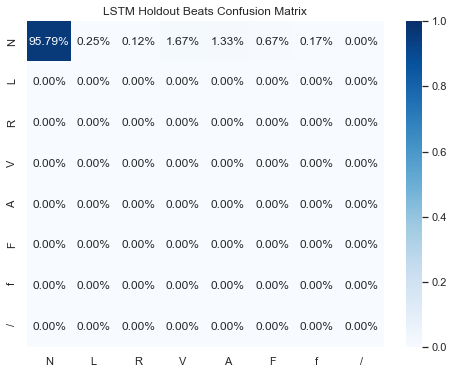

In [104]:
lstm_predict=np.argmax(lstmpredictions,axis=1)
lstm_actual_value=np.argmax(y_test1,axis=1)
lstm_results = showResults(lstm_actual_value, lstm_predict,'LSTM')

lstmmetrics = classification_report(lstm_actual_value, lstm_predict, digits=3)
categories=['N','L','R','V','A','F','f','/']
fig = plt.figure(figsize=(8,6))
LSTM_cf_m = lstm_results[5].astype('float')/ lstm_results[5].sum(axis=1)[:,np.newaxis]
sns.heatmap(np.nan_to_num(LSTM_cf_m),annot=True,fmt='.2%',xticklabels=categories,yticklabels=categories,vmin=0,vmax=1,cmap='Blues')
plt.title('LSTM Holdout Beats Confusion Matrix')
plt.show()
fig.savefig('cm.jpg', dpi = 400)

### Calculate the integrated gradients for the instances within the specified class

In [105]:
# Initialize the integrated gradients instance. We will use 50 steps to go from the 'baseline' to the input. The path 
# from baseline to input is defined by the Gauss-Legendre method.
ig  = IntegratedGradients(lstmmodel,
                          method = "gausslegendre",
                          n_steps = 50,
                          internal_batch_size = 100)

In [107]:
# Get the predictions of the cnn model:
nums = 10000
predictions = lstmmodel(X_test1[:nums,:]).numpy().argmax(axis=1)

# Calculate the integrated gradients for the specified class:
explanation = ig.explain(X_test1[:nums,:],
                         baselines = None,
                         target = predictions)

In [108]:
# Get attribution values from the explanations:
attrs = explanation.attributions[0].sum(axis=2)
print('Attributions shape:', attrs.shape)

# Normalize the attributes:
attrs = np.abs(attrs)
attrs_norm = (attrs - attrs.min(axis=1, keepdims=True)) / (attrs.max(axis=1, keepdims=True) - attrs.min(axis=1, keepdims=True))

Attributions shape: (2400, 275)


### Visualize Integrated Gradients with saliency maps for the correctly classified beats

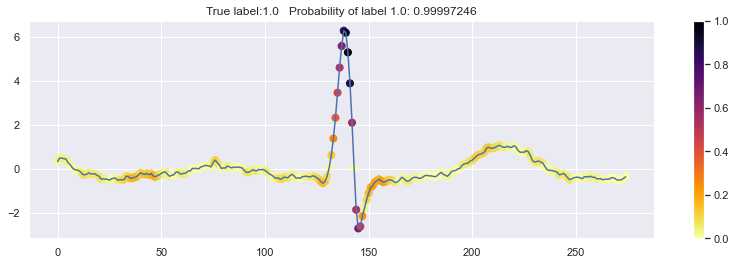

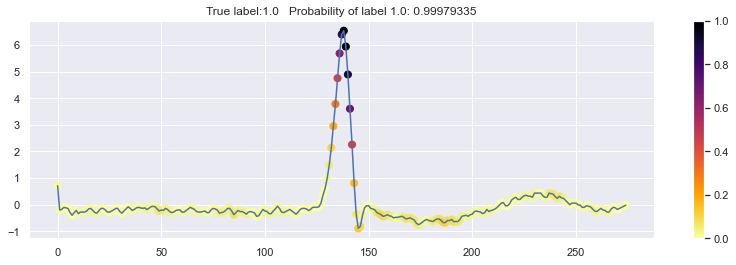

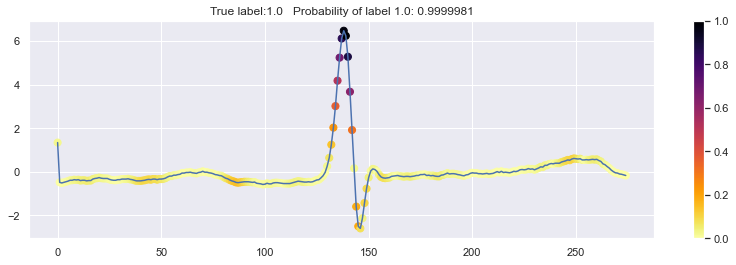

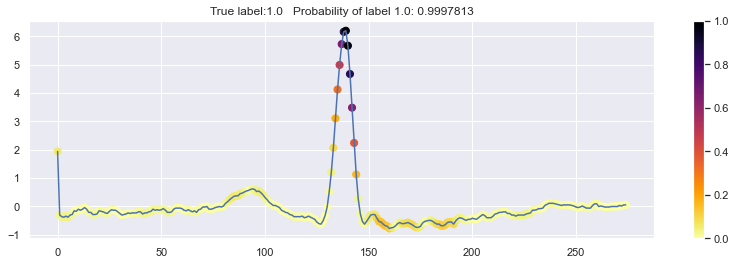

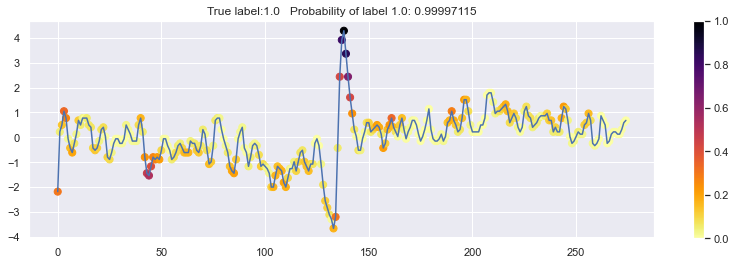

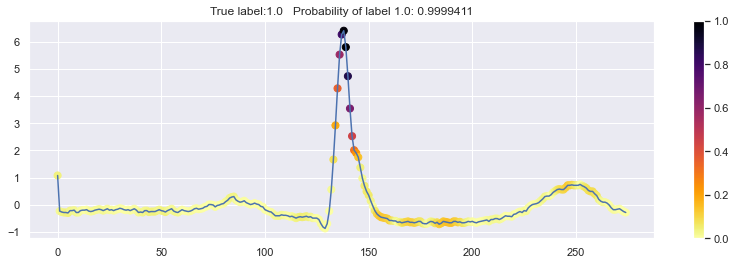

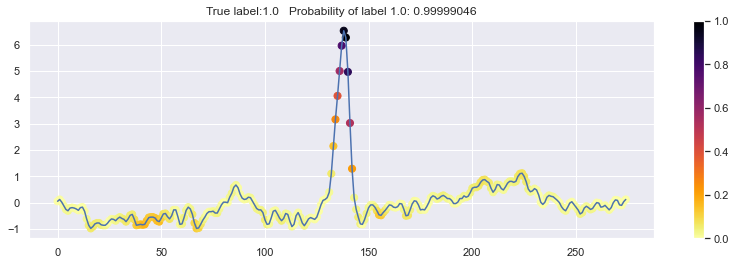

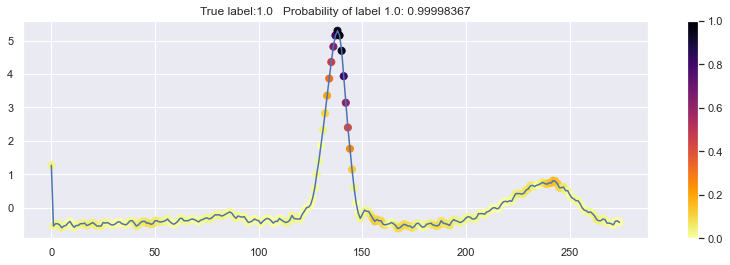

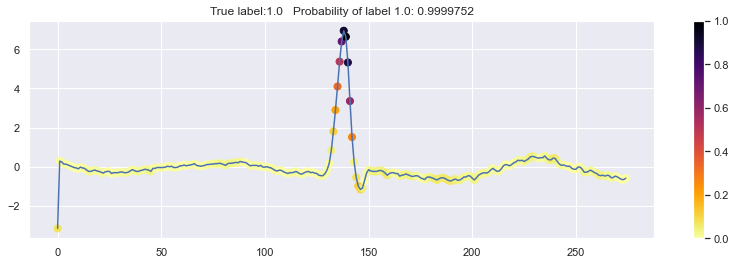

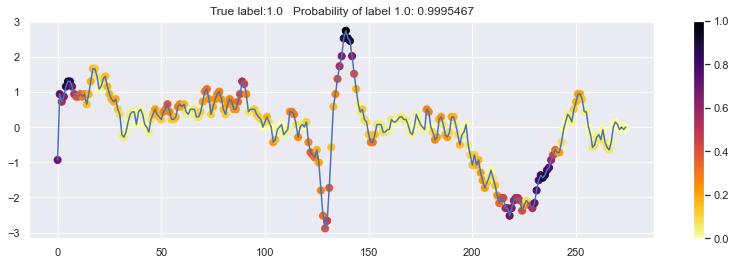

In [109]:
correct_attrs = np.where(lstm_predict==lstm_actual_value)
correct_attrs = correct_attrs[0].tolist()

for i in correct_attrs[:10]:
    plt.figure(figsize=(14, 4))
    plt.plot(X_test1[i].squeeze())
    plt.scatter(np.arange(len(X_test1[i])), X_test1[i].squeeze(), cmap='inferno_r', c=attrs_norm[i,:].squeeze(), s=50)
    plt.title('True label:' + str(y_test[i]) + '   Probability of label ' + str(y_test[i]) + ': ' + str(lstmpredictions[i][int(y_test[i])]))
    clim= np.ravel(attrs_norm)
    plt.clim(min(clim),max(clim))
    plt.colorbar()
    plt.show()

### Visualize Integrated Gradients with saliency maps for the heartbeats that were not correctly classified

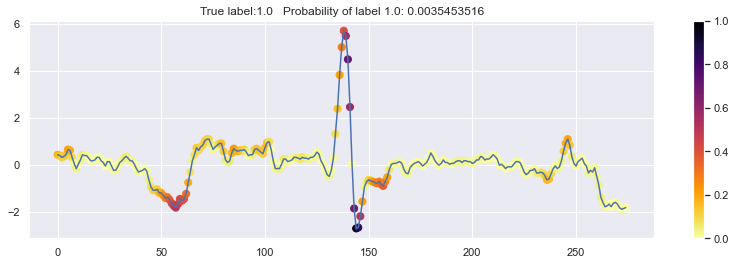

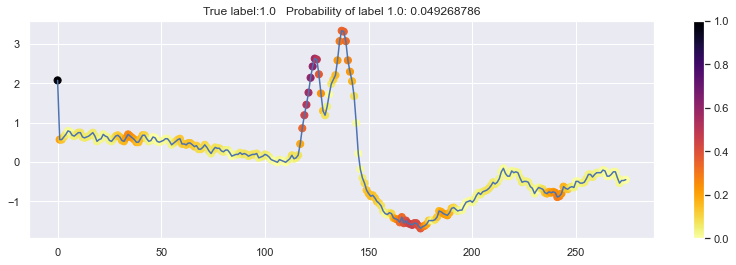

In [110]:
misclass_attrs = np.where(lstm_predict!=lstm_actual_value)
misclass_attrs = misclass_attrs[0].tolist()

for i in misclass_attrs[:2]:
    plt.figure(figsize=(14, 4))
    plt.plot(X_test1[i].squeeze())
    plt.scatter(np.arange(len(X_test1[i])), X_test1[i].squeeze(), cmap='inferno_r', c=attrs_norm[i,:].squeeze(), s=50)
    plt.title('True label:' + str(y_test[i]) + '   Probability of label ' + str(y_test[i]) + ': ' + str(lstmpredictions[i][int(y_test[i])]))
    clim= np.ravel(attrs_norm)
    plt.clim(min(clim),max(clim))
    plt.colorbar()
    plt.show()

### Divide the  ECG beats into 11 segments and compute the Integrated Gradients per segment

In [111]:
# Means of slice function:
def means_of_slices(iterable, slice_size):
    iterator = iter(iterable)
    while True:
        slice = list(islice(iterator, slice_size))
        if slice:
            yield np.sum(slice)/len(slice)
        else:
            return

# Divide the result into slices:
ig_per_segment = []
for i in range(len(attrs)):
    means = list(means_of_slices(attrs_norm[i], 25))
    ig_per_segment.append(means)
ig_per_segment = np.array(ig_per_segment)
print(ig_per_segment.shape)

# Repeat the values 25 times for visualization purposes:
ig_per_segment_repeat = []
for i in ig_per_segment:
    ig_per_segment_repeat.append(np.repeat(i, 25))
ig_per_segment_repeat = np.array(ig_per_segment_repeat)
print(ig_per_segment_repeat.shape)

(2400, 11)
(2400, 275)


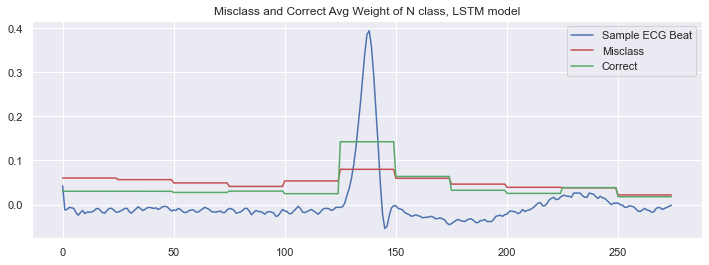

In [112]:
# Normalize correct and incorrect predictions and the ECG heartbeat:
ecg_correct_norm = normalize(ig_per_segment_repeat[correct_attrs])
ecg_incorrect_norm = normalize(ig_per_segment_repeat[misclass_attrs])
ecg_norm = normalize(X_test1[:, :, 0])

# Take means of all correct and incorrect segments:
mean_correct = ecg_correct_norm.mean(axis=0)
mean_incorrect = ecg_incorrect_norm.mean(axis=0)

fig = plt.figure(figsize=(12,4))
plt.plot(ecg_norm[1],color='b',label='Sample ECG Beat')
plt.plot(np.abs(mean_incorrect),color='r',label='Misclass')
plt.plot(np.abs(mean_correct),color='g',label='Correct')
plt.title('Misclass and Correct Avg Weight of ' + class_ann + ' class, LSTM model')
plt.legend()
plt.show()
fig.savefig('lstm_integrad_' + class_ann + '.jpg', dpi = 400)